In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#loading dataset

data = pd.read_csv('synthetic_asthma_dataset.csv')
#describing dataset
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               10000 non-null  object 
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   BMI                      10000 non-null  float64
 4   Smoking_Status           10000 non-null  object 
 5   Family_History           10000 non-null  int64  
 6   Allergies                7064 non-null   object 
 7   Air_Pollution_Level      10000 non-null  object 
 8   Physical_Activity_Level  10000 non-null  object 
 9   Occupation_Type          10000 non-null  object 
 10  Comorbidities            5033 non-null   object 
 11  Medication_Adherence     10000 non-null  float64
 12  Number_of_ER_Visits      10000 non-null  int64  
 13  Peak_Expiratory_Flow     10000 non-null  float64
 14  FeNO_Level             

In [3]:
#allergies, comorbidities, asthama_control level has missing values

#patient_id is useless, allergies has too many null values, can't use median cuz it can be null too, same for asthma control

df = data.drop(columns=['Patient_ID','Allergies','Asthma_Control_Level'])

#Filling Nan with most freq used

df['Comorbidities'] = df['Comorbidities'].fillna(df['Comorbidities'].mode()[0])


In [4]:
#choosing between label_encoding and onehot encoding in this step
#first seeing how many variations of each column has a unique value
val = list(df.columns)
for i in val:
    if df[i].dtype == object:
        print(i,"\t",df[i].unique())

Gender 	 ['Female' 'Male' 'Other']
Smoking_Status 	 ['Former' 'Never' 'Current']
Air_Pollution_Level 	 ['Moderate' 'Low' 'High']
Physical_Activity_Level 	 ['Sedentary' 'Moderate' 'Active']
Occupation_Type 	 ['Outdoor' 'Indoor']
Comorbidities 	 ['Diabetes' 'Both' 'Hypertension']


In [5]:
#Will use ordinal and one hot as label isn't preffered for logistic n i might use that
# won't be scaling cuz using random forest
#ordinal
target = ['Air_Pollution_Level','Physical_Activity_Level','Occupation_Type']

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

cat = [
    ["Low","Moderate","High"],                # Air_Pollution_Level
    ["Sedentary","Moderate","Active"],        # Physical_Activity_Level
    ["Indoor","Outdoor"],                     # Occupation_Type
]
encoder = OrdinalEncoder(categories=cat)
df[target]=encoder.fit_transform(df[target])


In [12]:
target2 = ['Smoking_Status','Gender','Comorbidities']
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')

encoded_array = encoder.fit_transform(df[target2])

encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(target2), index=df.index)

df_encoded = pd.concat([df.drop(columns=target2), encoded_df], axis=1)



In [7]:
#for logistic we require numerical data so label encoding, random forest doesn't care so usinf this instead of one hot
"""from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in target2:
    df[i] = le.fit_transform(df[i])"""

'from sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\nfor i in target2:\n    df[i] = le.fit_transform(df[i])'

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Data = df_encoded.drop(columns=['Has_Asthma'])

for i in target:
    df_encoded[i] = sc.fit_transform(df[[i]])

In [15]:
y = df_encoded['Has_Asthma']
X = Data

In [16]:
#now training stuff from above target and independant values
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(X_train.shape, X_test.shape)

(8000, 19) (2000, 19)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

log = LogisticRegression( penalty='l2', C=1.0,solver='lbfgs',max_iter=1000,random_state=42)
svm  = SVC( kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42)
tree = RandomForestClassifier()

clf = [log, svm, tree]
for model in clf:
    print(model)
    model.fit(X_train, y_train)
    print(f'score --> {model.score(X_test, y_test)}')

LogisticRegression(max_iter=1000, random_state=42)


c:\Users\HP\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score --> 0.8785
SVC(random_state=42)
score --> 0.7565
RandomForestClassifier()
score --> 0.9195


In [18]:
# Model making
model = RandomForestClassifier(n_estimators=100, random_state=42)

# executing model on training data
model.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1 Prediction
y_pred = model.predict(X_test)

# Step 2 Accuracy check
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")



Model Accuracy: 92.05%


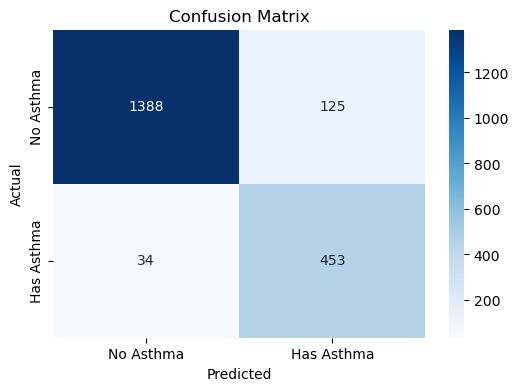

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Asthma", "Has Asthma"], yticklabels=["No Asthma", "Has Asthma"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Asthma", "Has Asthma"]))

Classification Report:

              precision    recall  f1-score   support

   No Asthma       0.98      0.92      0.95      1513
  Has Asthma       0.78      0.93      0.85       487

    accuracy                           0.92      2000
   macro avg       0.88      0.92      0.90      2000
weighted avg       0.93      0.92      0.92      2000

